In [7]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os


# process load time data
systems = ['dlcache', 'baseline']
compute_time = [0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4]
batch_size = [256, 512, 1024, 2048]
repeats = 1
data = []

for s in systems:
    for r in range(repeats):
        for b in batch_size:
            for c in compute_time:
                try:
                    dir = "{}/data/run{}/{}/{}".format(s, r, c, b)
                    load_time = np.load('{}/load_time.npy'.format(dir))[0]
                    if os.path.exists('{}/train_cache_usage.npy'.format(dir)):
                        avg_cache_usage = np.load('{}/train_cache_usage.npy'.format(dir))
                        avg_cache_usage = np.mean(avg_cache_usage, dtype=int)
                        cache_hits = 0
                        for ch in glob.glob("{}/cache_hits*".format(dir)):
                            cache_hits += np.load(ch)
                        cache_hit_rate = cache_hits / (b * 100)
                    else:
                        avg_cache_usage = 0
                        cache_hit_rate = 0

                    data.append([s, c, b, load_time, avg_cache_usage, cache_hit_rate])
                except:
                    pass

data = pd.DataFrame(data, columns=['system', 'compute_time', 'batch_size', 'load_time', 'avg_cache_usage', 'cache_hit_rate'])
data.sort_values(by='compute_time', inplace=True)
data.to_csv('data.csv', index=False)
data

,system,compute_time,batch_size,load_time,avg_cache_usage,cache_hit_rate
0,dlcache,0.4,256,22.657148,1768,0.749102
24,baseline,0.4,256,33.676606,0,0.000000
57,baseline,0.4,2048,518.500931,0,0.000000
46,baseline,0.4,1024,243.189389,0,0.000000
6,dlcache,0.4,512,93.366931,1949,0.391504
...,...,...,...,...,...,...
66,baseline,2.2,2048,830.867805,0,0.000000
45,baseline,2.4,512,52.936421,0,0.000000
34,baseline,2.4,256,9.936320,0,0.000000
56,baseline,2.4,1024,309.457678,0,0.000000


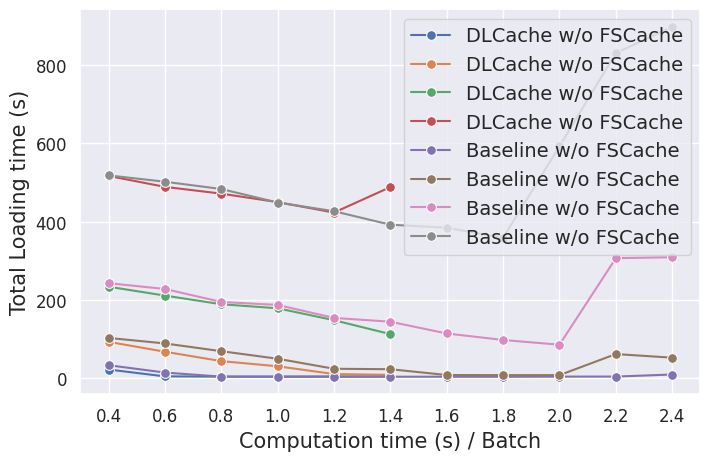

In [8]:
compute_time = data['compute_time'].unique().tolist()
sns.set(style='darkgrid',)
sns.set(rc={'figure.figsize':(8, 5)})

for s in systems:
    for b in batch_size:
        slice = data[(data['system']==s) & (data['batch_size']==b)].sort_values(by='compute_time')
        compute_time_ticks = []
        for ct in slice['compute_time']:
            compute_time_ticks.append(compute_time.index(ct))
        slice['compute_time'] = compute_time_ticks
        if len(slice) > 0:
            if s == 'dlcache':
                label = 'DLCache w/o FSCache'
            else:
                label = 'Baseline w/o FSCache'
                
            sns.lineplot(x='compute_time', y='load_time', data=slice, label=label, marker= '.', markersize=14)

plt.xticks(np.arange(len(compute_time)), compute_time, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Computation time (s) / Batch', fontsize = 15)
plt.ylabel('Total Loading time (s)', fontsize = 15)
plt.legend(fontsize=14)
plt.show()

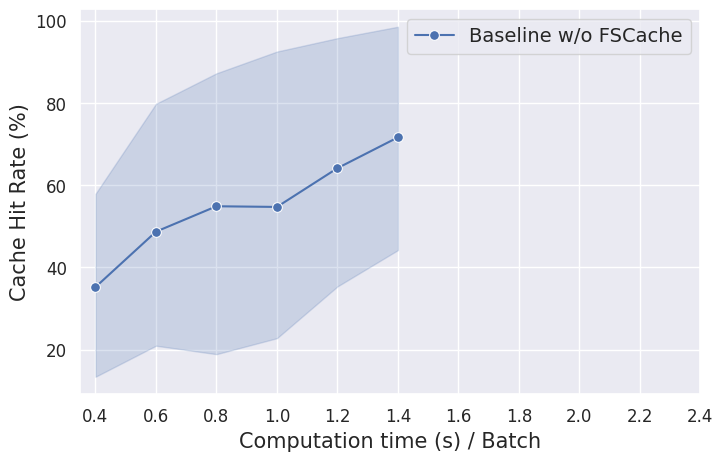

In [9]:

slice = data[(data['system']=='dlcache')].sort_values(by='compute_time')
compute_time_ticks = []
for ct in slice['compute_time']:
    compute_time_ticks.append(compute_time.index(ct))
slice['compute_time'] = compute_time_ticks
slice['cache_hit_rate'] *= 100.0
if len(slice) > 0:
    ilabel = 'DLCache w/ FSCache'
    sns.lineplot(x='compute_time', y='cache_hit_rate', data=slice, label=label, marker= '.', markersize=14)

plt.xticks(np.arange(len(compute_time)), compute_time, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Computation time (s) / Batch', fontsize = 15)
plt.ylabel('Cache Hit Rate (%)', fontsize = 15)
plt.legend(fontsize=14)
plt.show()